In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import mygene, glob
import seaborn as sns
%matplotlib inline

In [3]:
#sns.set_style("white")
#sns.set_context("talk", font_scale=1.2, rc={"lines.linewidth": 1.5})
sns.set_theme(context='talk', style='white', palette=sns.color_palette("Set2"), font='sans-serif', font_scale=1.2, color_codes=True, rc={"lines.linewidth": 1.5})

In [4]:
structural_category_order = ['full-splice_match', 'incomplete-splice_match', 'novel_in_catalog', 'novel_not_in_catalog', 'intergenic', 'genic', 'fusion', 'antisense', 'genic_intron']
structural_category_label = ['FSM', 'ISM', 'NIC', 'NNC', 'Intergenic', 'Genic', 'Fusion', 'Antisense', 'Genic Intron']

# Reference transcriptomes

In [5]:
def readGFF3(file):
    data = pd.read_csv(file, sep='\t', comment='#', names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'phase', 'attribute'], index_col = False)
    e = data['attribute'].str.extractall('([a-zA-Z0-9_]+)=([a-zA-Z0-9_\-\.]+);?')
    a = pd.Series(e.values[:, 1], [e.index.get_level_values(0), e.values[:, 0]])
    if a.index.duplicated().sum() > 0:
        a.index = pd.MultiIndex.from_arrays([a.index.get_level_values(0), a.groupby(level=[0,1]).cumcount().index.get_level_values(1) + a.groupby(level=[0,1]).cumcount().astype(str).replace('0','').values])
    attr = a.unstack()
    data = data.drop(['attribute'], axis=1).join(attr)
    return data

In [6]:
annotated_gff = readGFF3("../Results/Annotated/all_samples.gff3")
annotated_transcripts = annotated_gff[annotated_gff['feature'] == 'mRNA']
annotated_transcripts.loc[:, 'num_exons'] = annotated_transcripts['num_exons'].astype(int)

/home/pengsc/bin/miniconda3/envs/jupyter/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


# Overall Stats

Total novel and known genes and transcripts identified from PacBio data

Text(0.5, 0.98, 'Number of Unique Genes and Transcripts')

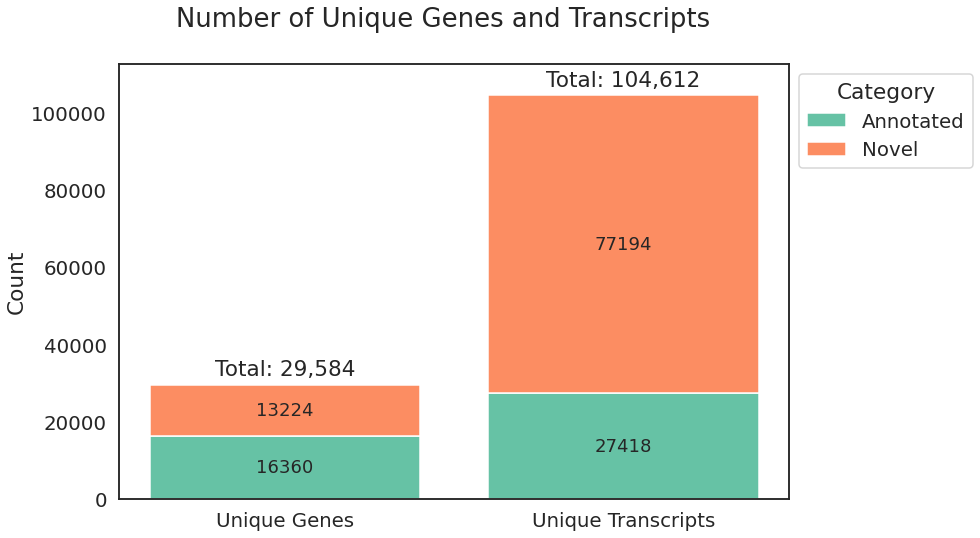

In [7]:
unique_gene = len(annotated_transcripts['Parent'].unique())
novel_gene = sum([True if i.startswith('novelGene') else False for i in annotated_transcripts['Parent'].unique()])
unique_tx = annotated_transcripts.shape[0]
novel_tx = annotated_transcripts[~annotated_transcripts['structural_category'].isin(['full-splice_match', 'incomplete-splice_match'])].shape[0]

fig, ax = plt.subplots(figsize = (12, 8))
colors = sns.color_palette("Set2").as_hex()
ax.bar(x = ['Unique Genes', 'Unique Transcripts'], height = (unique_gene - novel_gene, unique_tx - novel_tx), color = colors[0], edgecolor = 'white', label = 'Annotated')
ax.bar_label(ax.containers[0], label_type = 'center', fontsize = 18)
ax.bar(x = ['Unique Genes', 'Unique Transcripts'], height = (novel_gene, novel_tx), color = colors[1], edgecolor = 'white', label = 'Novel', bottom = (unique_gene - novel_gene, unique_tx - novel_tx))
ax.bar_label(ax.containers[1], label_type = 'center', fontsize = 18)
ax.bar_label(ax.containers[1], label_type = 'edge', labels = ["Total: {:,}".format(unique_gene), "Total: {:,}".format(unique_tx)], padding = 5)
plt.legend(loc='best', bbox_to_anchor=(1,1), ncol=1, title = "Category")
ax.set_ylabel('Count')
ax.set_ylim(0, unique_tx+8000)
plt.suptitle("Number of Unique Genes and Transcripts")

# Structural Category Breakdown
Number of transcripts by their stuctural category.  
Novel not-in-catalog transcripts contitute the majority of transcripts idenrtified

[Text(0, 0, 'FSM'),
 Text(0, 1, 'ISM'),
 Text(0, 2, 'NIC'),
 Text(0, 3, 'NNC'),
 Text(0, 4, 'Intergenic'),
 Text(0, 5, 'Genic'),
 Text(0, 6, 'Fusion'),
 Text(0, 7, 'Antisense'),
 Text(0, 8, 'Genic Intron')]

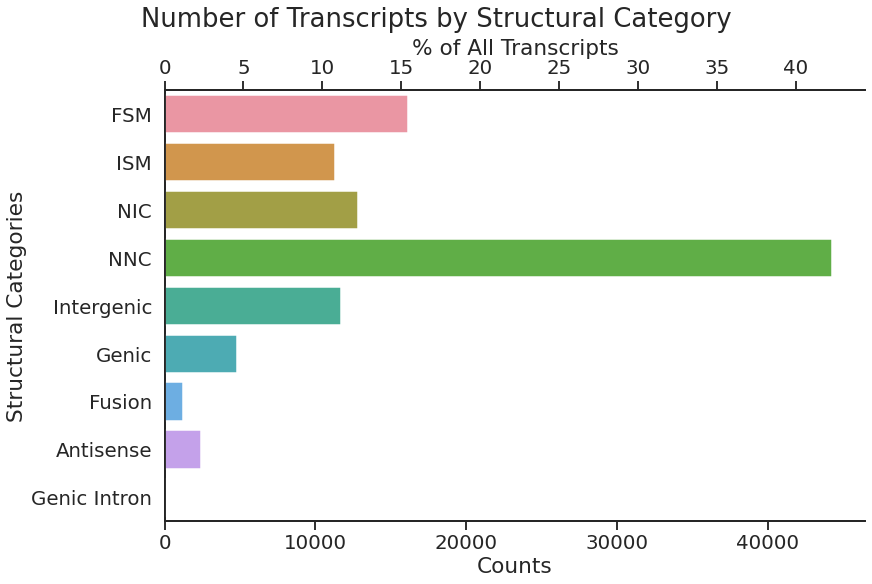

In [11]:
cat_count = annotated_transcripts.groupby('structural_category').count()[['chrom']]
cat_count['percent'] = (cat_count['chrom'] * 100) / cat_count['chrom'].sum()
cat_count = cat_count.reset_index()
fig, ax = plt.subplots(figsize = (12, 8), constrained_layout=True)
ax2 = ax.twiny()
sns.barplot(data = cat_count, y = 'structural_category', x = 'chrom', ax = ax, order = structural_category_order)
sns.barplot(data = cat_count, y = 'structural_category', x = 'percent', ax = ax2, order = structural_category_order)
sns.despine(top = False)
ax.set_ylabel('Structural Categories')
ax.set_xlabel('Counts')
ax2.set_xlabel('% of All Transcripts')
plt.suptitle("Number of Transcripts by Structural Category")
ax.set_yticklabels(labels = structural_category_label)

# Isoforms

Here we examine number of isoforms per gene and its ditribution.  
Most novel genes have a single isoform, consistent with them being non-coding genes.

In [12]:
numIsoforms = pd.DataFrame(annotated_transcripts.groupby('Parent').apply(lambda x: True if np.any(x['Parent'].str.startswith('novelGene')) else False), columns = ['novelGene'])
numIsoforms = numIsoforms.join(pd.DataFrame(annotated_transcripts.groupby('Parent').apply(lambda x: x.shape[0]), columns = ['numIsoforms']))

0 18.17848410757946 96.54416212946158 #66c2a5
1 25.501222493887532 2.767695099818512 #fc8d62
2 18.685819070904646 0.49909255898366606 #8da0cb
3 37.63447432762836 0.18905021173623715 #e78ac3


Text(0.5, 0.98, 'Number of Isoforms per Gene')

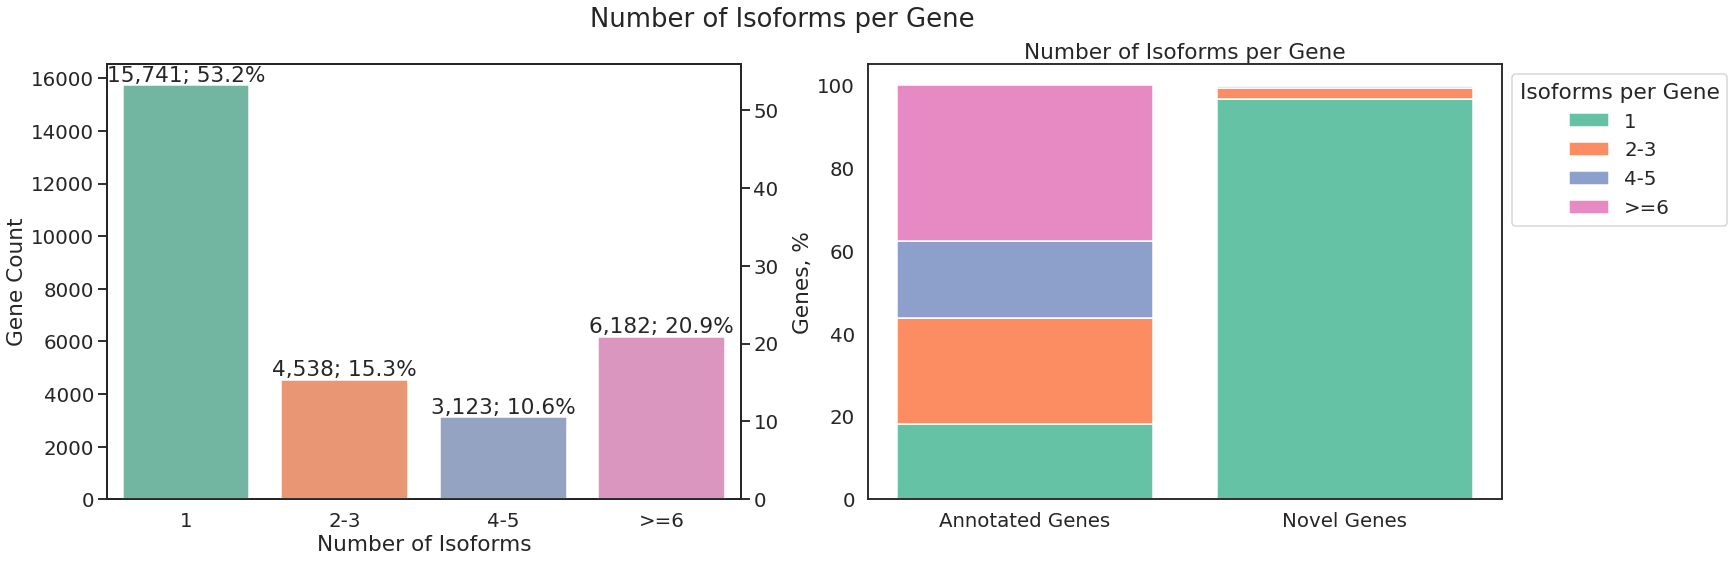

In [13]:
bins = [1, 2, 4, 6, np.inf]
counts = np.histogram(numIsoforms['numIsoforms'], bins)[0]
fig, axes = plt.subplots(1, 2, figsize = (25, 8))
ax2 = axes[0].twinx()
sns.barplot(y = counts, x = ['1', '2-3', '4-5', '>=6'], ax = axes[0])
sns.barplot(y = (counts * 100) / counts.sum(), x = ['1', '2-3', '4-5', '>=6'], ax = ax2)
axes[0].set_ylabel('Gene Count')
axes[0].set_xlabel('Number of Isoforms')

axes[0].bar_label(axes[0].containers[0], labels = ['{:,}; {}%'.format(i, round(j,1)) for i, j in zip(counts, (counts * 100) / counts.sum())])

counts, counts_novel = (i for i,j in numIsoforms.groupby('novelGene')['numIsoforms'].apply(np.histogram, bins = bins))
counts = (counts * 100) / counts.sum()
counts_novel = (counts_novel * 100) / counts_novel.sum()
colors = sns.color_palette("Set2").as_hex()
labels = ['1', '2-3', '4-5', '>=6']
i = 0
for i in range(0,len(counts)):
    print(i, counts[i], counts_novel[i], colors[i])
    axes[1].bar(x = ['Annotated Genes', 'Novel Genes'], height = (counts[i], counts_novel[i]), color = colors[i], edgecolor = 'white', label = labels[i], bottom = (counts[:i].sum() if i>0 else 0, counts_novel[:i].sum() if i >0 else 0))
axes[1].legend(loc='best', bbox_to_anchor=(1,1), ncol=1, title = "Isoforms per Gene")
axes[1].set_ylabel('Genes, %')
axes[1].set_title("Number of Isoforms per Gene")

plt.suptitle("Number of Isoforms per Gene")

# Mono- vs Multi-Exon Transcripts

Transcripts by number of exons.
Mono-exonic transcripts are more likely to be intergenic, genic, or antisense, which are all non-coding

Text(0.5, 0.98, 'Mono- and Multi-exon Transcripts')

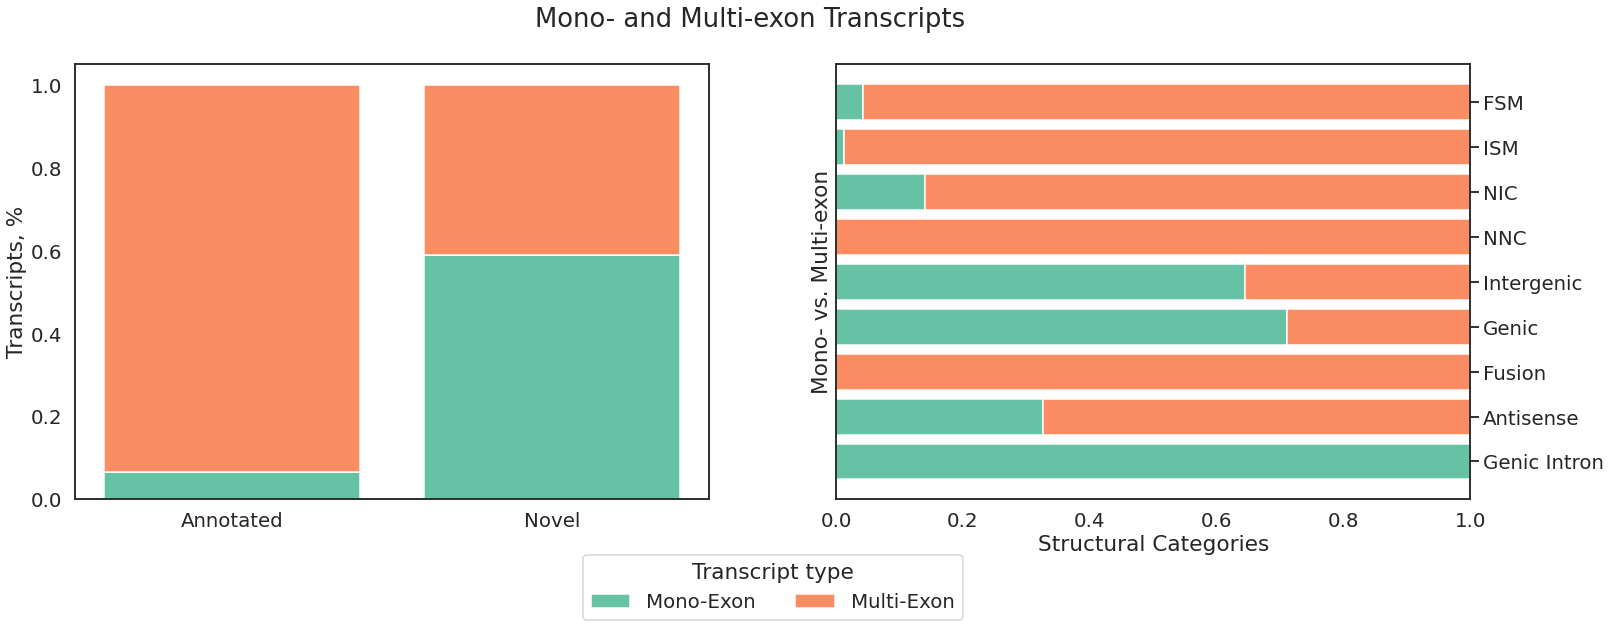

In [14]:
multiExon = pd.DataFrame([annotated_transcripts['num_exons'] > 1, annotated_transcripts['Parent'].str.startswith('novelGene'), annotated_transcripts['end'] - annotated_transcripts['start'] + 1], index = ['multiExon', 'novelGene', 'length']).transpose()
multiExon['multiExon'] = multiExon['multiExon'].replace(1, 'Multi-Exon').replace(0, 'Mono-Exon')
multiExon['novelGene'] = multiExon['novelGene'].replace(1, 'Novel').replace(0, 'Annotated')
multiExon['length'] = multiExon['length'] / 1000

fig, axes = plt.subplots(1, 2, figsize = (25, 8))
#sns.boxplot(data = multiExon, x = 'novelGene', y = 'length', hue = 'multiExon', ax = ax)
labels = ['Mono-Exon', 'Multi-Exon']

exon_by_structure = annotated_transcripts[['structural_category', 'num_exons']].copy()
exon_by_structure['multiExon'] = np.where(annotated_transcripts['num_exons'] > 1, 'Multi-Exon', 'Mono-Exon')
exon_by_structure = exon_by_structure[['structural_category', 'multiExon']]
exon_by_structure_perc = exon_by_structure.reset_index().groupby(['structural_category', 'multiExon']).count().reset_index().pivot(columns = 'structural_category', values = 'index', index = 'multiExon').apply(lambda x: x/x.sum(), axis = 0).fillna(0)
exon_by_structure_perc.columns = exon_by_structure_perc.columns.astype("category").rename_categories({i: j for i, j in zip(structural_category_order, structural_category_label)}).reorder_categories(structural_category_label)
exon_by_structure_perc = exon_by_structure_perc.sort_index(axis = 1)

i = 0
for i in range(0,len(exon_by_structure_perc)):
    #print(i, counts[i], counts_novel[i], colors[i])
    axes[1].barh(y = structural_category_label[::-1], width = exon_by_structure_perc.to_numpy()[i,::-1], color = colors[i], edgecolor = 'white', label = labels[i], left = exon_by_structure_perc.to_numpy()[:i,::-1].sum(axis = 0))

axes[1].set_ylabel('Mono- vs. Multi-exon')
axes[1].set_xlabel('Structural Categories')
axes[1].legend().remove()
#axes[0].set_title("Transcript Length")
axes[1].yaxis.tick_right()
#axes[1].yaxis.set_label_position("right")

percent = multiExon.groupby(['novelGene', 'multiExon'])['length'].count().reset_index().groupby('novelGene').apply(lambda x: x['length'] / x['length'].sum())
annotated = percent[:2]
novel = percent[2:]
colors = sns.color_palette("Set2").as_hex()

i = 0
for i in range(0,len(annotated)):
    #print(i, counts[i], counts_novel[i], colors[i])
    axes[0].bar(x = ['Annotated', 'Novel'], height = (annotated[i], novel[i]), color = colors[i], edgecolor = 'white', label = labels[i], bottom = (annotated[:i].sum() if i>0 else 0, novel[:i].sum() if i >0 else 0))
plt.legend(loc='lower center', bbox_to_anchor=(-0.1,-0.3), ncol=2, title = "Transcript type")
axes[0].set_ylabel('Transcripts, %')
#axes[1].set_title("Mono- vs Multi-Exon by Annotation")
plt.suptitle("Mono- and Multi-exon Transcripts")

Text(0.5, 0.98, 'Exon Counts by Structural Category')

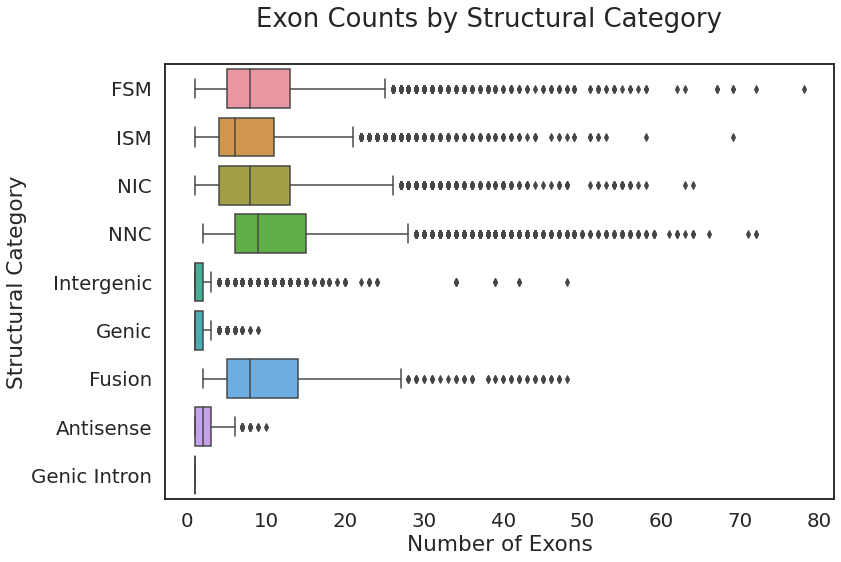

In [15]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.boxplot(data = annotated_transcripts, x = 'num_exons', y = 'structural_category', ax = ax, order = structural_category_order)
ax.set_ylabel('Structural Category')
ax.set_xlabel("Number of Exons")
ax.set_yticklabels(labels = structural_category_label)
plt.suptitle('Exon Counts by Structural Category')

# Transcript Length

Text(0.5, 0.98, 'Transcript Length by Structural Category')

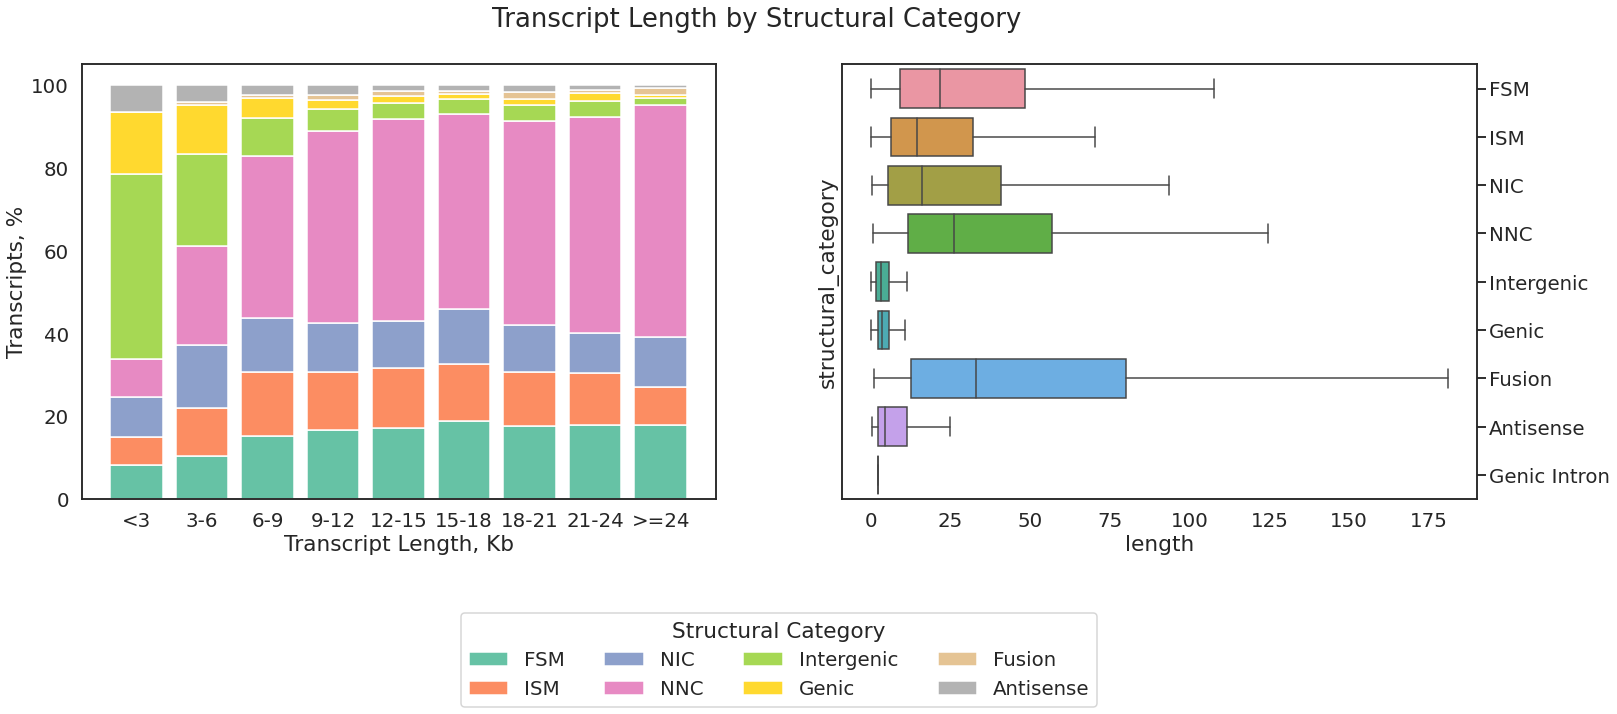

In [17]:
bins = list(range(0, 27, 3)) + [np.inf]
binned_counts = pd.DataFrame(annotated_transcripts.groupby('structural_category').apply(lambda x: (x['end'] - x['start'] + 1) / 1000), columns = ['length']).reset_index()[['structural_category', 'length']].groupby('structural_category').apply(np.histogram, bins = bins)
binned_counts.index = binned_counts.index.astype("category").rename_categories({i: j for i, j in zip(structural_category_order, structural_category_label)}).reorder_categories(structural_category_label)
binned_counts = binned_counts.sort_index()
binned_counts = binned_counts[:len(binned_counts)-1]
binned_percent = np.array([i for i, j in binned_counts])
binned_percent = 100 * binned_percent / binned_percent.sum(axis = 0)
fig, axes = plt.subplots(1, 2, figsize = (25, 8))
colors = sns.color_palette("Set2").as_hex()
xlabels = ['<3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-24', '>=24']
labels = binned_counts.index
i = 0
for i in range(0,len(binned_counts)):
    height = binned_percent[i][:]
    axes[0].bar(x = xlabels, height = height, color = colors[i], edgecolor = 'white', label = labels[i], bottom = binned_percent[:i, :].sum(axis = 0))
axes[0].legend(loc='lower center', bbox_to_anchor=(1.1,-0.5), ncol=4, title = "Structural Category")
axes[0].set_ylabel('Transcripts, %')
axes[0].set_xlabel("Transcript Length, Kb")

sns.boxplot(data = pd.DataFrame(annotated_transcripts.groupby('structural_category').apply(lambda x: (x['end'] - x['start'] + 1) / 1000), columns = ['length']).reset_index()[['structural_category', 'length']], 
            y = 'structural_category', x = 'length', showfliers = False, ax = axes[1], order = structural_category_order)
axes[1].yaxis.tick_right()
axes[1].set_yticklabels(labels = structural_category_label)

fig.suptitle("Transcript Length by Structural Category")

# Gene Expression

In [18]:
expression_df = pd.DataFrame()
for i in glob.glob("../Results/salmon/annotated/AH*/quant.sf"):
    expression = pd.read_csv(i, sep = '\t', index_col = 0)[['NumReads']]
    sample = i.split('/')[4]
    expression.columns = [sample]
    expression_df = expression.join(expression_df)

In [19]:
def normalize_read_count(df):
    # Normalize gene expression against both library depth and composition
    # Get geometric mean
    df_log = np.log2(df)
    geom_mean = df_log.mean(axis = 1)
    # Remove genes/tx with no expression
    records_to_keep = geom_mean[~(geom_mean==-np.inf)].index
    geom_mean = geom_mean[geom_mean.index.isin(records_to_keep)]
    df_log = df_log[df_log.index.isin(records_to_keep)]
    # Subtract geom mean from log values
    df_log_ratio = df_log.apply(lambda x: x - geom_mean, axis = 0)
    # Calculate scaling factors
    sample_median = df_log_ratio.median()
    sample_scaling_factor = np.power(2, sample_median)
    
    # Scale original read counts
    df_scaled = df.apply(lambda x: x / sample_scaling_factor, axis = 1)
    
    return df_scaled


In [20]:
expression_df_mean = normalize_read_count(expression_df).mean(axis = 1)
# Aggregate to gene level
gene_expression_df = expression_df.join(annotated_transcripts[['ID', 'Parent']].set_index('ID')).drop_duplicates().groupby('Parent').sum()

# Normalization
gene_expression_df_mean = normalize_read_count(gene_expression_df).mean(axis = 1)

gene_expression_df_mean = pd.DataFrame(gene_expression_df_mean, columns = ['mean_counts']).reset_index()
gene_expression_df_mean['novelGene'] = gene_expression_df_mean['Parent'].str.startswith('novelGene')

[Text(1, 0, 'FSM'),
 Text(1, 1, 'ISM'),
 Text(1, 2, 'NIC'),
 Text(1, 3, 'NNC'),
 Text(1, 4, 'Intergenic'),
 Text(1, 5, 'Genic'),
 Text(1, 6, 'Fusion'),
 Text(1, 7, 'Antisense'),
 Text(1, 8, 'Genic Intron')]

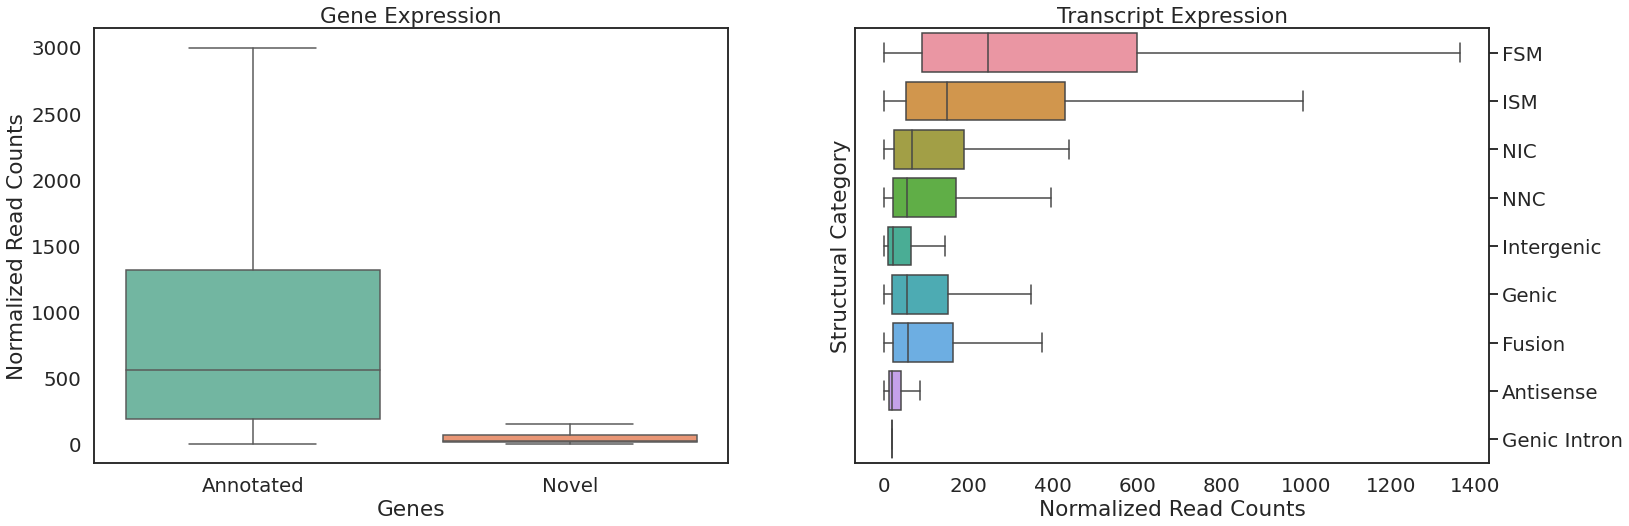

In [21]:
fig, axes = plt.subplots(1, 2, figsize = (25, 8))
sns.boxplot(data = gene_expression_df_mean, x = 'novelGene', y = 'mean_counts', showfliers = False, ax = axes[0])
#sns.violinplot(data = gene_expression_df_mean[gene_expression_df_mean['mean_counts']<12000], x = 'novelGene', y = 'mean_counts', ax = ax, inner = 'box')
axes[0].set_ylabel('Normalized Read Counts')
axes[0].set_xlabel("Genes")
axes[0].set_title("Gene Expression")
axes[0].set_xticklabels(['Annotated', 'Novel'])

sns.boxplot(data = pd.DataFrame(expression_df_mean, columns = ['mean_counts']).reset_index().merge(annotated_transcripts, left_on = 'Name', right_on = 'ID'), 
            y = 'structural_category', x = 'mean_counts', showfliers = False, ax = axes[1], order = structural_category_order)
axes[1].set_xlabel('Normalized Read Counts')
axes[1].set_ylabel("Structural Category")
axes[1].set_title("Transcript Expression")
axes[1].yaxis.tick_right()
axes[1].set_yticklabels(labels = structural_category_label)

# Flow cell counts

In [22]:
classification = pd.read_csv("../Results/SQANTI3/all_samples_classification_TPM.txt", sep = '\t')
classification['txID'] = classification['associated_transcript'].str.replace('transcript:', '')
ID_mapping = annotated_transcripts[annotated_transcripts['ID'].str.startswith('PB')][['ID', 'ID']]
ID_mapping.columns = ['ID', 'isoform']
ID_mapping = pd.concat([annotated_transcripts[['ID']].merge(classification[['isoform', 'txID']], left_on = 'ID', right_on = 'txID')[['ID', 'isoform']], ID_mapping])
FL_TPM = annotated_transcripts.merge(ID_mapping, left_on = 'ID', right_on = 'ID', how = 'left').merge(classification[['FL_TPM', 'isoform', 'coding']])[['ID', 'Parent', 'structural_category', 'FL_TPM', 'coding']]
FL_TPM['FL_TPM_log'] = np.log2(FL_TPM['FL_TPM'] + 1)
FL_TPM['novelGene'] = FL_TPM['Parent'].str.startswith('novelGene')

Text(0.5, 0.98, 'Full Length Read Count')

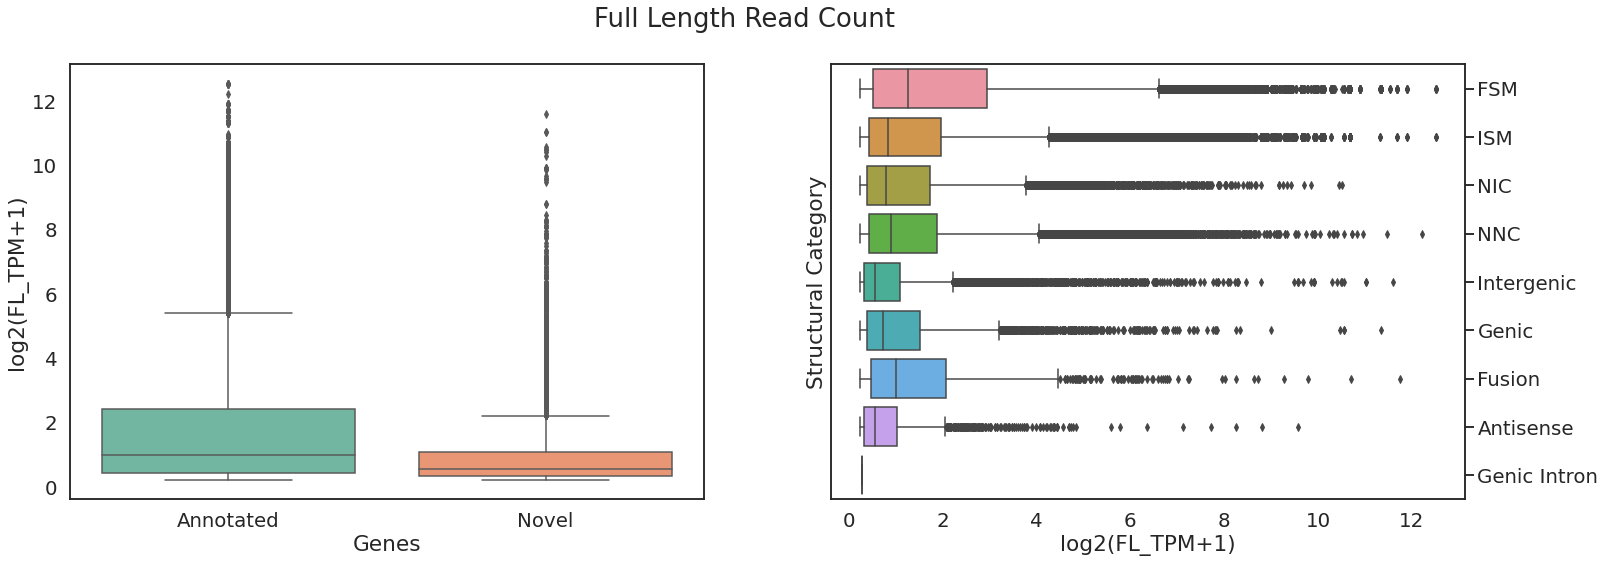

In [23]:
fig, axes = plt.subplots(1, 2, figsize = (25, 8))
sns.boxplot(data = FL_TPM, x = 'novelGene', y = 'FL_TPM_log', showfliers = True, ax = axes[0])
#sns.violinplot(data = gene_expression_df_mean[gene_expression_df_mean['mean_counts']<12000], x = 'novelGene', y = 'mean_counts', ax = ax, inner = 'box')
axes[0].set_ylabel('log2(FL_TPM+1)')
axes[0].set_xlabel("Genes")
axes[0].set_xticklabels(['Annotated', 'Novel'])

sns.boxplot(data = FL_TPM, y = 'structural_category', x = 'FL_TPM_log', showfliers = True, ax = axes[1], order = structural_category_order)
axes[1].set_ylabel('Structural Category')
axes[1].set_xlabel("log2(FL_TPM+1)")
axes[1].yaxis.tick_right()
axes[1].set_yticklabels(labels = structural_category_label)
plt.suptitle("Full Length Read Count")

# Coding vs Non-coding

Predict coding vs non-coding genes based on presence of ORFs.  
Consistent with previous results, integenic, genic, and antisense transcripts are enriched in non-coding transcripts

Text(0.5, 0.98, 'Coding vs Non-coding by Structural Category')

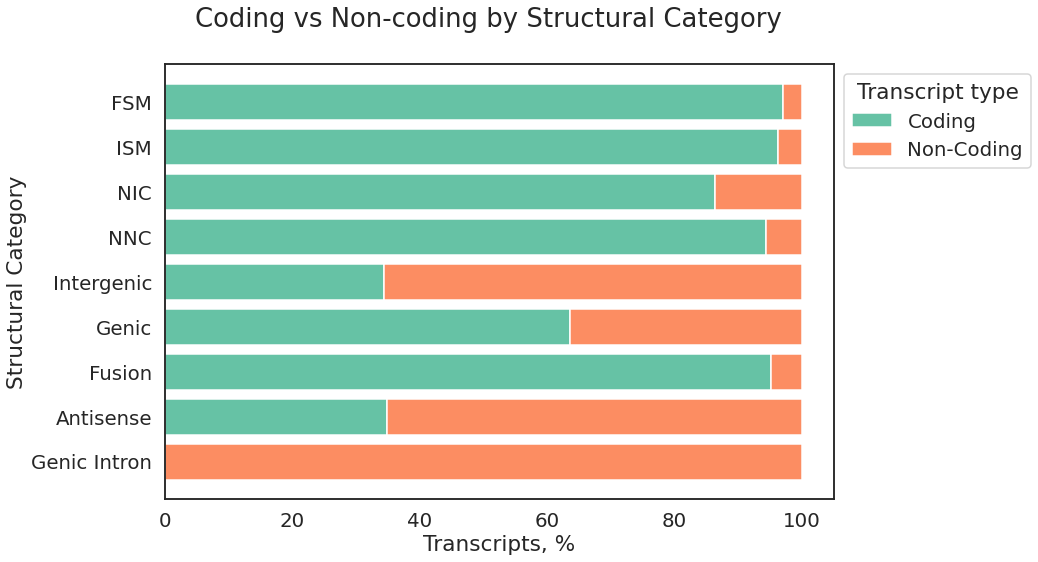

In [24]:
coding_perc = pd.DataFrame((FL_TPM.groupby(['structural_category']).apply(lambda x: x.groupby('coding')['ID'].count() / x['ID'].count()) * 100)).reset_index().pivot(index='structural_category', columns='coding', values='ID').fillna(0)
coding_perc.index = coding_perc.index.astype("category").rename_categories({i: j for i, j in zip(structural_category_order, structural_category_label)}).reorder_categories(structural_category_label)
coding_perc = coding_perc.sort_index(ascending = False)

fig, ax = plt.subplots(figsize = (12, 8))
colors = sns.color_palette("Set2").as_hex()
labels = ['Coding', 'Non-Coding']
xlabels = coding_perc.index
i = 0
for i in range(0,coding_perc.shape[1]):
    #print(i, counts[i], counts_novel[i], colors[i])
    ax.barh(y = xlabels, width = coding_perc.to_numpy()[:, i], color = colors[i], edgecolor = 'white', label = labels[i], left = coding_perc.to_numpy()[:,:i].sum(axis = 1))
plt.legend(loc='best', bbox_to_anchor=(1,1), ncol=1, title = "Transcript type")
ax.set_xlabel('Transcripts, %')
ax.set_ylabel('Structural Category')
plt.suptitle("Coding vs Non-coding by Structural Category")

# Splice Junctions
As a quality control, we look for low levels of non-canonical splice junctions in novel isoforms

In [25]:
junctions = pd.read_csv("../Results/SQANTI3/all_samples_junctions.txt", sep = '\t')
junction_count = annotated_transcripts.merge(ID_mapping, left_on = 'ID', right_on = 'ID').merge(junctions, left_on = 'isoform', right_on = 'isoform')[['ID', 'structural_category', 'junction_category', 'canonical']].groupby('structural_category').apply(lambda x: x.groupby(['junction_category', 'canonical'])['ID'].count()).reset_index()
junction_count['junction_type'] = junction_count['junction_category'] + " " + junction_count['canonical']
junction_percent = junction_count[['structural_category', 'junction_type', 'ID']].copy()
junction_percent['percent'] = junction_percent.groupby(['structural_category']).apply(lambda x: x['ID'] / x['ID'].sum()).reset_index()['ID']
junction_percent = junction_percent[['structural_category', 'junction_type', 'percent']].pivot(index='structural_category', columns='junction_type', values='percent').fillna(0)*100
junction_percent.index = junction_percent.index.astype("category").rename_categories({i: j for i, j in zip(structural_category_order, structural_category_label)}).reorder_categories(structural_category_label[:-1])
junction_percent = junction_percent.sort_index(ascending = False)

Text(0.5, 1.0, 'Splice Junction Type by Structural Category')

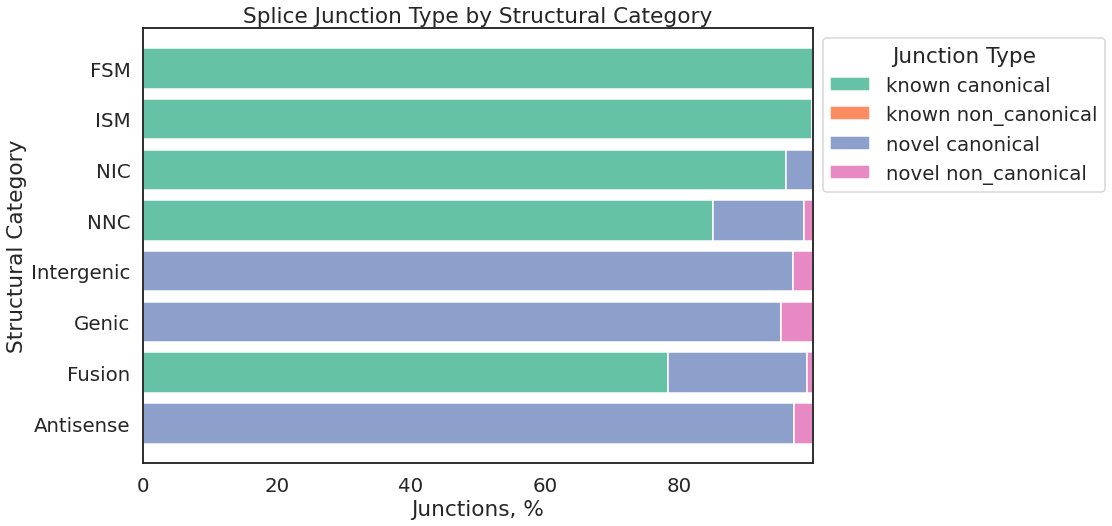

In [26]:
fig, ax = plt.subplots(figsize = (12, 8))
colors = sns.color_palette("Set2").as_hex()
labels = junction_percent.columns
xlabels = junction_percent.index
i = 0
for i in range(0,junction_percent.shape[1]):
    #print(i, counts[i], counts_novel[i], colors[i])
    ax.barh(y = xlabels, width = junction_percent.to_numpy()[:, i], color = colors[i], edgecolor = 'white', label = labels[i], left = junction_percent.to_numpy()[:,:i].sum(axis = 1))
plt.legend(loc='best', bbox_to_anchor=(1,1), ncol=1, title = "Junction Type")
ax.set_xlabel('Junctions, %')
ax.set_ylabel('Structural Category')
ax.set_title("Splice Junction Type by Structural Category")

# Intrapriming
This identifies transcripts potentially intra-primmed (>60% As in 20bp immediately downstream of TTS)

Text(0.5, 0.98, 'Potential Intrapriming by Structural Category')

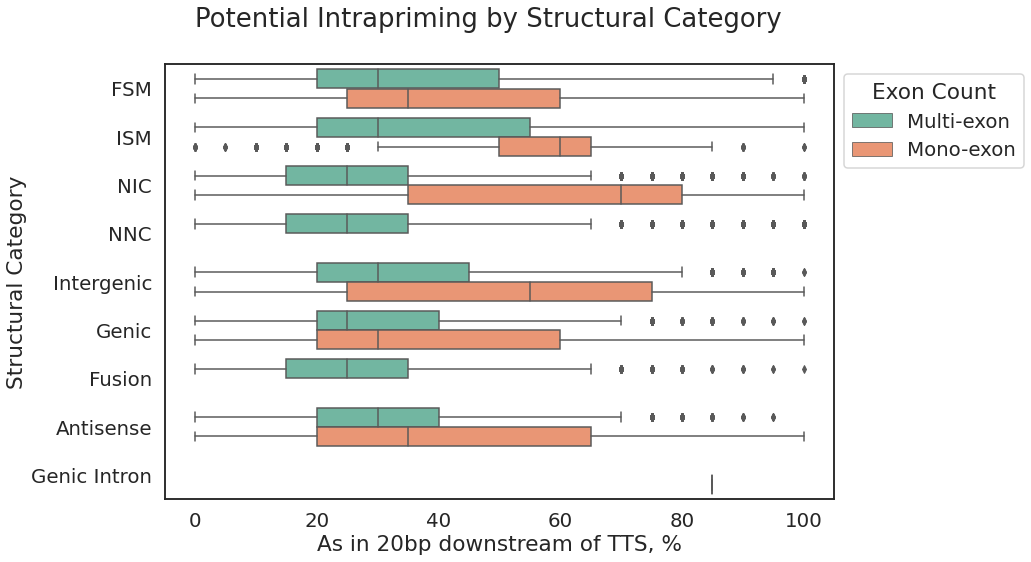

In [27]:
intrapriming = annotated_transcripts.merge(ID_mapping, left_on = 'ID', right_on = 'ID').merge(classification[['isoform', 'perc_A_downstream_TTS']], left_on = 'isoform', right_on = 'isoform')
intrapriming['monoExon'] = np.where(intrapriming['num_exons'] == 1, 'Mono-exon', 'Multi-exon')
fig, ax = plt.subplots(figsize = (12, 8))
sns.boxplot(data = intrapriming, y = 'structural_category', x = 'perc_A_downstream_TTS', hue = 'monoExon', ax = ax, order = structural_category_order)
ax.set_xlabel('As in 20bp downstream of TTS, %')
ax.set_ylabel('Structural Category')

ax.legend(loc='best', bbox_to_anchor=(1,1), ncol=1, title = "Exon Count")
ax.set_yticklabels(labels = structural_category_label)
plt.suptitle("Potential Intrapriming by Structural Category")

# TSS ratio
We use mRNAseq coverage ratio up- and down-stream of TSS to assess quality of our 5' annotation.  
$log_{2}\frac{RNA-seq Cov_{upstream}}{RNA-seq Cov_{downstream}}<0$ indicates more RNA-seq reads aligning to upstream of TSS, suggesting incomplete TSS.  
Majority of transcripts have a positive coverage ratio, confirming complete 5' annotation

Text(0.5, 0.98, "5' Completeness by mRNA-seq coverage around TSS")

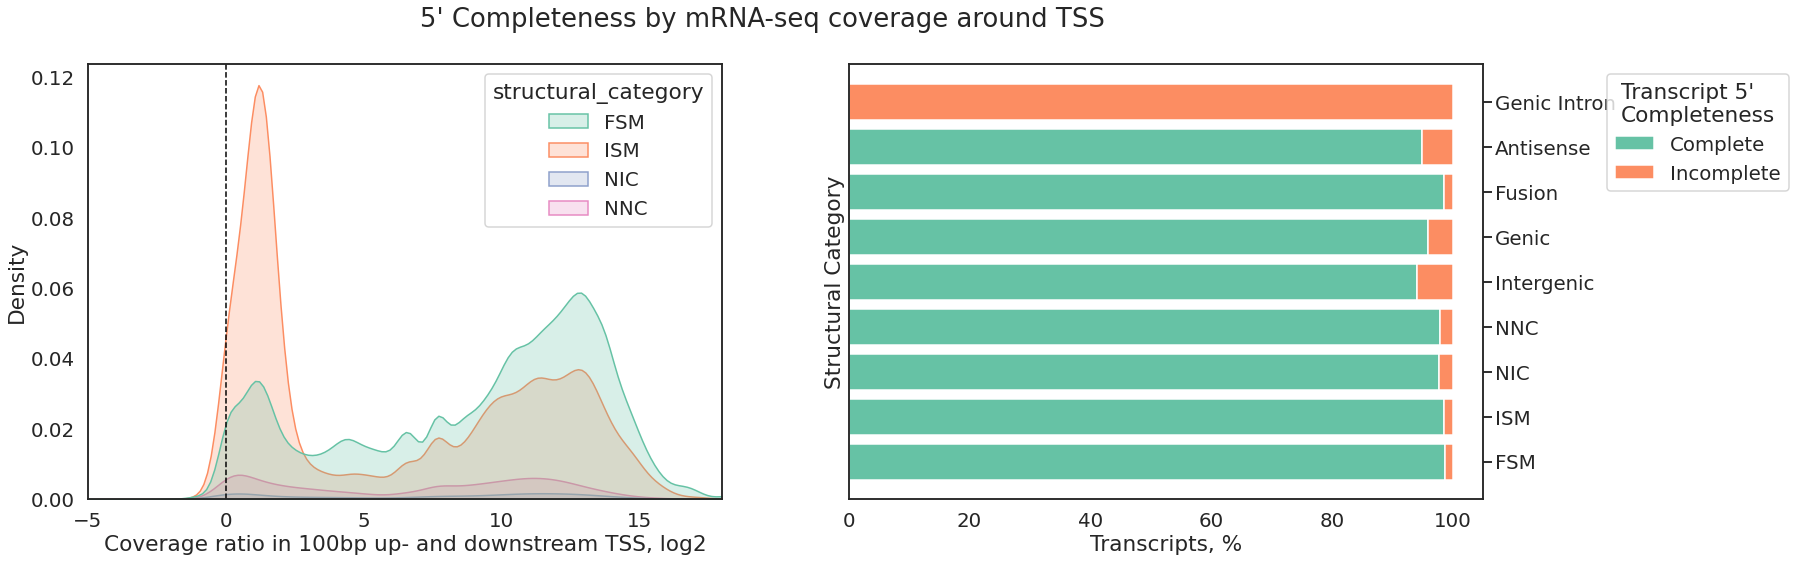

In [34]:
TSS = annotated_transcripts.merge(ID_mapping, left_on = 'ID', right_on = 'ID').merge(classification[['isoform', 'ratio_TSS']], left_on = 'isoform', right_on = 'isoform')[['ID', 'ratio_TSS', 'structural_category']]
TSS['ratio_TSS_log2'] = np.log2(TSS['ratio_TSS'])
TSS.structural_category = TSS.structural_category.astype("category").cat.rename_categories({i: j for i, j in zip(structural_category_order, structural_category_label)}).cat.reorder_categories(structural_category_label)
TSS = TSS.sort_values('structural_category', ascending = False)
TSS['TSS_enriched'] = TSS['ratio_TSS_log2'] > 0
TSS_perc = 100 * TSS.groupby('structural_category').apply(lambda x: x['TSS_enriched'].sum() / x.shape[0])#.sort_index(ascending = False)

cat_to_plot = structural_category_label[:4]
fig, axes = plt.subplots(1, 2, figsize = (25, 8))
sns.kdeplot(data = TSS[TSS['structural_category'].isin(cat_to_plot)], x = 'ratio_TSS_log2', hue = 'structural_category', ax = axes[0], fill = True, hue_order = structural_category_label[:4], multiple = 'layer')
axes[0].set_xlabel('Coverage ratio in 100bp up- and downstream TSS, log2')
axes[0].set_ylabel('Density')
#axes[0].set_title("Coverage ratio in 100bp up- and downstream TSS, log2")
axes[0].set_xlim(-5,18)
axes[0].axvline(x = 0, color = 'black', linestyle = 'dashed', label = 'Equal Coverage Line')

colors = sns.color_palette("Set2").as_hex()
labels = ['Complete', 'Incomplete']
xlabels = TSS_perc.index
#i = 0
#for i in range(0,junction_percent.shape[1]):
    #print(i, counts[i], counts_novel[i], colors[i])
axes[1].barh(y = xlabels, width = TSS_perc.to_numpy(), color = colors[0], edgecolor = 'white', label = labels[0])
axes[1].barh(y = xlabels, width = 100 - TSS_perc.to_numpy(), color = colors[1], edgecolor = 'white', label = labels[1], left = TSS_perc.to_numpy())

plt.legend(loc='best', bbox_to_anchor=(1.18,1), ncol=1, title = "Transcript 5'\nCompleteness")
axes[1].set_xlabel('Transcripts, %')
axes[1].set_ylabel('Structural Category')
#axes[1].set_title("Transcript 5' Completeness")
axes[1].yaxis.tick_right()

plt.suptitle("5' Completeness by mRNA-seq coverage around TSS")

# Distance to annotated TSS and TES

In [8]:
def readGTF(file):
    data = pd.read_csv(file, sep='\t', comment='#', names=['chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute'])
    e = data['attribute'].str.extractall('([a-zA-Z0-9_]+)\s\"([a-zA-Z0-9:]+)\";')
    a = pd.Series(e.values[:, 1], [e.index.get_level_values(0), e.values[:, 0]])
    if a.index.duplicated().sum() > 0:
        a.index = pd.MultiIndex.from_arrays([a.index.get_level_values(0), a.groupby(level=[0,1]).cumcount().index.get_level_values(1) + a.groupby(level=[0,1]).cumcount().astype(str).replace('0','').values])
    attr = a.unstack()
    data = data.drop(['attribute'], axis=1).join(attr)
    return data

ref = readGTF("../data/ensembl.ref.gtf")
ref_tx = ref[ref['feature'] == 'transcript']
ref_tx['transcript_id'] = ref_tx['transcript_id'].str.replace('transcript:', '')
ref_tx = ref_tx[['start', 'end', 'chrom', 'transcript_id', 'strand']]

/home/pengsc/bin/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [31]:
dist_df = annotated_transcripts[annotated_transcripts['structural_category'].isin(['full-splice_match', 'incomplete-splice_match'])].merge(ref_tx, left_on = ['ID', 'strand', 'chrom'], right_on = ['transcript_id', 'strand', 'chrom'], validate = 'm:1', suffixes = ['_PB', '_ref'])
dist_df['dist_TSS'] = -np.where(dist_df['strand'] == '+', dist_df['start_PB'] - dist_df['start_ref'], dist_df['end_ref'] - dist_df['end_PB'])
dist_df['dist_TTS'] = -np.where(dist_df['strand'] == '+', dist_df['end_ref'] - dist_df['end_PB'], dist_df['start_PB'] - dist_df['start_ref'])

Text(0.2, -0.1, "Negative values indicate shorter 5' or 3' ends")

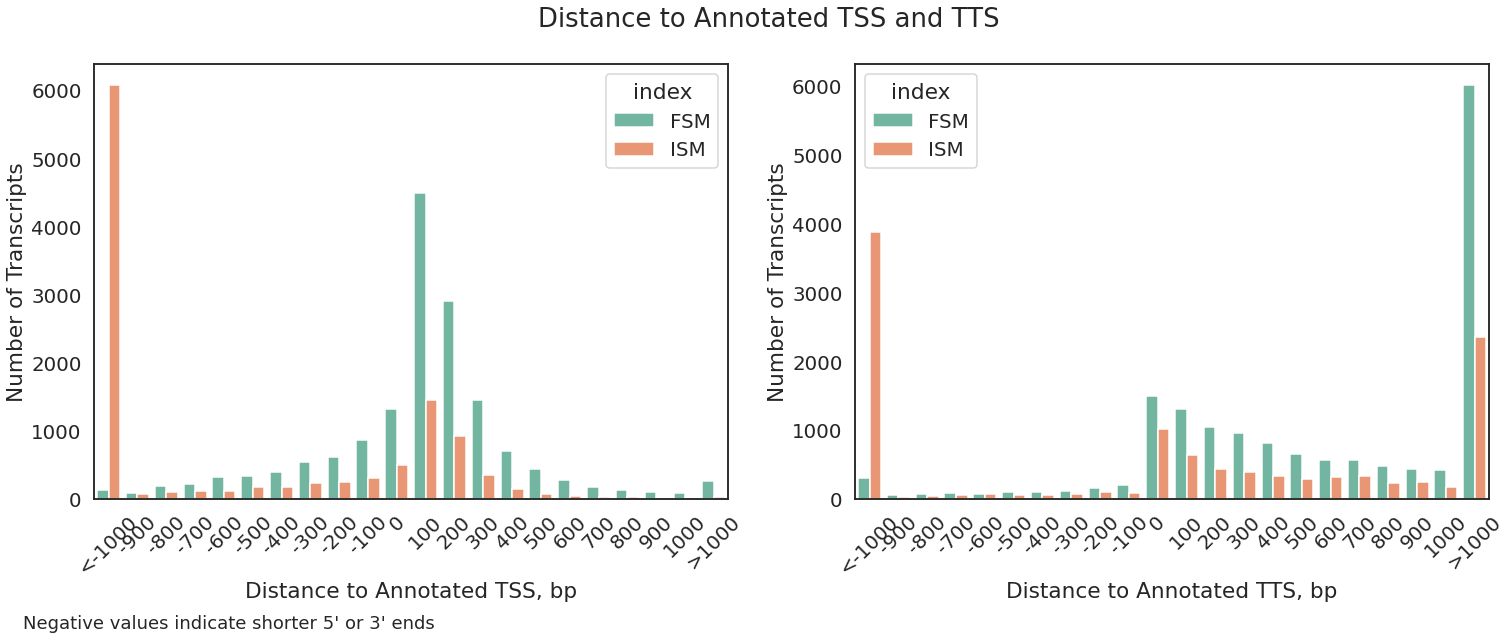

In [32]:
bins = [-np.inf] + list(range(-1000, 1100, 100)) + [np.inf]
intervals = ['<-1000'] + list(range(-900, 1100, 100)) + ['>1000']
TSS_dist_FSM = pd.DataFrame(np.histogram(dist_df[dist_df['structural_category'] == 'full-splice_match']['dist_TSS'], bins = bins)[0], index = ['FSM']*(len(bins) - 1), columns = ['count']).reset_index()
TTS_dist_FSM = pd.DataFrame(np.histogram(dist_df[dist_df['structural_category'] == 'full-splice_match']['dist_TTS'], bins = bins)[0], index = ['FSM']*(len(bins) - 1), columns = ['count']).reset_index()
TSS_dist_ISM = pd.DataFrame(np.histogram(dist_df[dist_df['structural_category'] == 'incomplete-splice_match']['dist_TSS'], bins = bins)[0], index = ['ISM']*(len(bins) - 1), columns = ['count']).reset_index()
TTS_dist_ISM = pd.DataFrame(np.histogram(dist_df[dist_df['structural_category'] == 'incomplete-splice_match']['dist_TTS'], bins = bins)[0], index = ['ISM']*(len(bins) - 1), columns = ['count']).reset_index()


TSS_dist = pd.concat([TSS_dist_FSM, TSS_dist_ISM])
TSS_dist['interval'] = intervals * 2
TTS_dist = pd.concat([TTS_dist_FSM, TTS_dist_ISM])
TTS_dist['interval'] = intervals * 2
colors = sns.color_palette("Set2").as_hex()
fig, axes = plt.subplots(1, 2, figsize = (25, 8))
sns.barplot(data = TSS_dist,x = 'interval', y = 'count', ax = axes[0], hue = 'index')
axes[0].set_xticklabels(labels = intervals, rotation = 45)
#axes[0].set_title('Distance to Annotated TSS')
axes[0].set_ylabel('Number of Transcripts')
axes[0].set_xlabel("Distance to Annotated TSS, bp")

sns.barplot(data = TTS_dist,x = 'interval', y = 'count', ax = axes[1], hue = 'index')
axes[1].set_xticklabels(labels = intervals, rotation = 45)
axes[1].set_xticklabels(labels = intervals, rotation = 45)
#axes[1].set_title('Distance to Annotated TTS')
axes[1].set_ylabel('Number of Transcripts')
axes[1].set_xlabel("Distance to Annotated TTS, bp")

plt.suptitle("Distance to Annotated TSS and TTS")
plt.figtext(0.2, -0.1, "Negative values indicate shorter 5' or 3' ends", wrap=True, horizontalalignment='center', fontsize=18)

# ATAC profile
Similarly, ATAC coverage profile near TSS confirms complete annotation at 5'

In [4]:
profile = pd.read_csv("../Results/figures/profile/all_samples.tab", sep = '\t', skiprows = 1)
profile[['sample', 'tissue']] = profile['bins'].str.split('_', expand = True)
profile = profile.drop(['Unnamed: 1', 'bins'], axis = 1)
profile = pd.melt(profile, id_vars=['sample', 'tissue'], var_name = 'bins', value_name = 'Normalized Count')

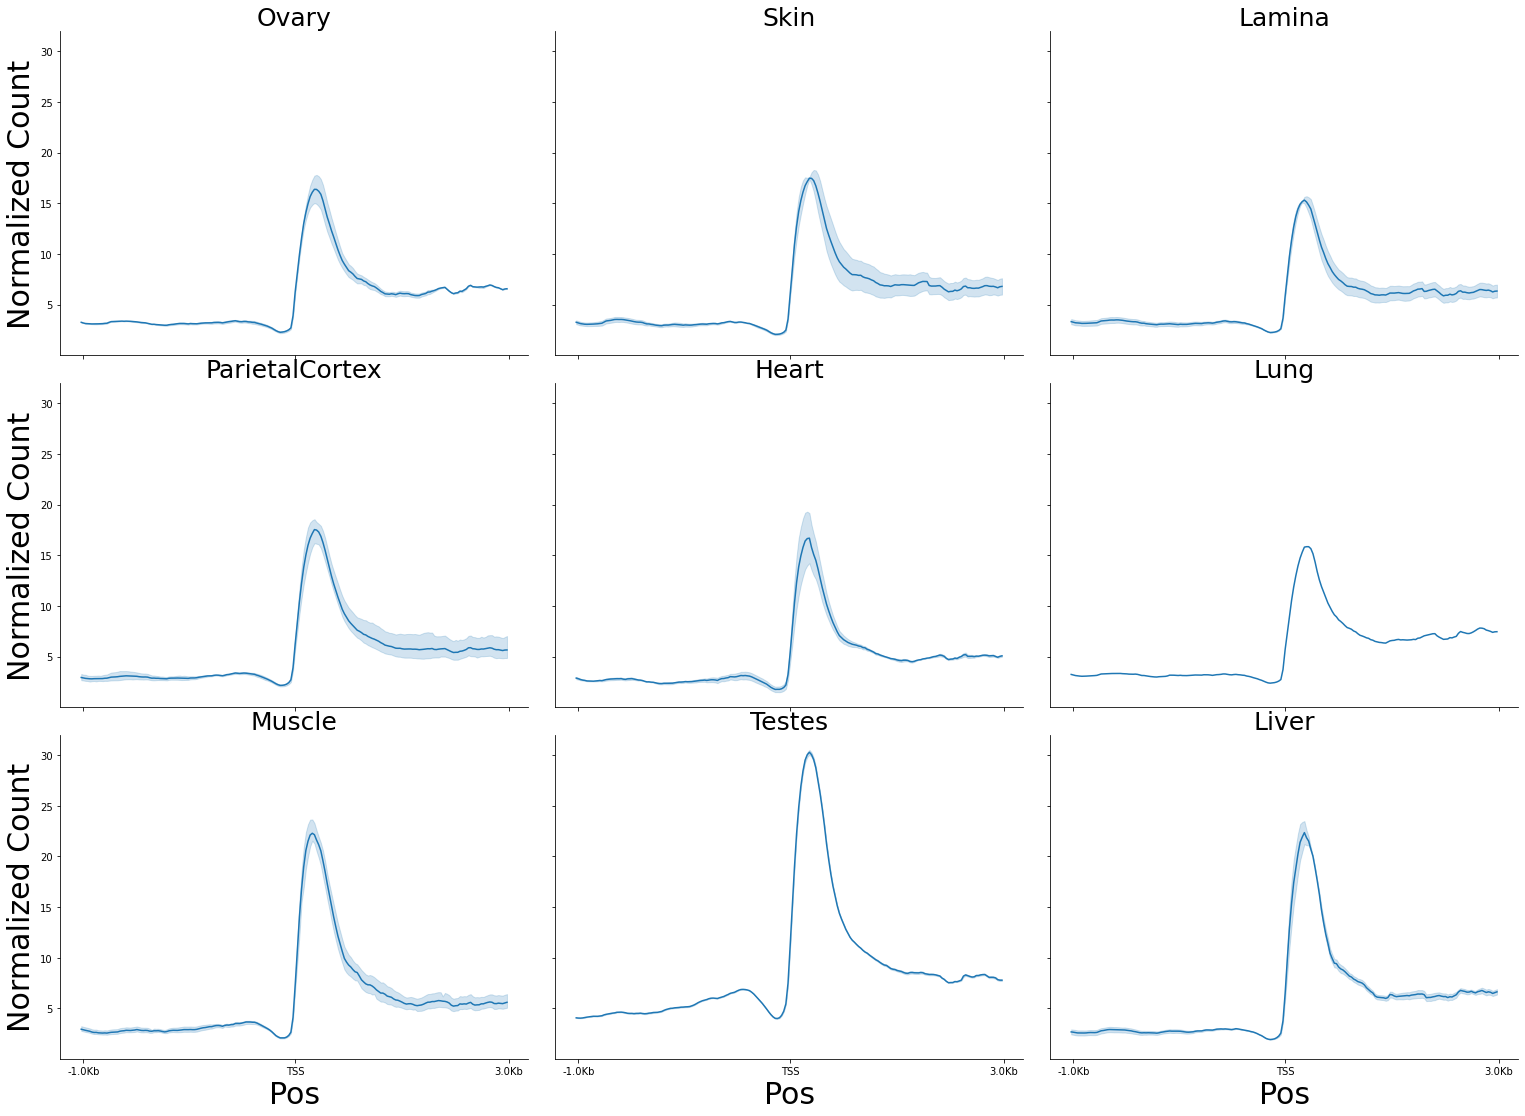

In [12]:
grid = sns.FacetGrid(data = profile, col_wrap = 3, col = 'tissue', sharex = True, sharey = True, height = 5, aspect = 7/5)
grid.map_dataframe(sns.lineplot, x = 'bins', y = 'Normalized Count')
for ax in grid.axes.flat:
    ax.set_xticks([1, 100, 200])
    ax.set_xticklabels(labels = ['-1.0Kb', 'TSS', '3.0Kb'])
    plt.setp(ax.texts, text="")
#grid.add_legend(title = 'Tissue', fontsize = 20)
grid = grid.set_titles(col_template = '{col_name}', size = 25)
grid = grid.set_xlabels('Pos', fontsize = 30)
grid = grid.set_ylabels('Normalized Count', fontsize = 30)